This script is dedicated to explore the departments (de: Ressort) with relation to the author mapping.

In [1]:
import json
import sqlite3
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import networkx as nx
from dateutil import relativedelta
from datetime import datetime
import re
import tqdm
from src.models.MatchingType import MatchingType

In [2]:
con = sqlite3.connect('../data/interim/articles_with_author_mapping.db')
cur = con.cursor()

In [3]:
# get top 30 authors
rows = cur.execute('select name from unmapped_authors where matching_type = ? group by name order by count(*) desc limit 50', (MatchingType.IS_FULL_NAME,)).fetchall()
authors = [row[0] for row in rows]

In [4]:
# remove  None from authors
authors = [author for author in authors if author is not None]

In [5]:
authors

['Ekkehard Schulreich',
 'André Neumann',
 'Julia Tonne',
 'Nikos Natsidis',
 'Olaf Barth',
 'Christian Kunze',
 'Thomas Sparrer',
 'Christine Jacob',
 'Jörg ter Vehn',
 'Heike Liesaus',
 'Dirk Wurzel',
 'Simone Prenzel',
 'Frank Prenzel',
 'Jens Rometsch',
 'Matthias Puppe',
 'Steffi Robak',
 'Thomas Haegeler',
 'Axel Kaminski',
 'Ulrike Witt',
 'Jens Rosenkranz',
 'Matthias Roth',
 'Steffen Brost',
 'Mathias Orbeck',
 'Kerstin Decker',
 'Ilka Fischer',
 'Frank Pfeifer',
 'Kathrin Kabelitz',
 'Jana Brechlin',
 'Frank Hörügel',
 'Andreas Tappert',
 'Frank Schmidt',
 'Kay Würker',
 'Frank Döring',
 'Nico Fliegner',
 'Haig Latchinian',
 'Olaf Krenz',
 'Roland Heinrich',
 'Kai-Uwe Brandt',
 'Olaf Büchel',
 'Roger Dietze',
 'Robert Nößler',
 'Hagen Rösner',
 'Evelyn ter Vehn',
 'Bastian Fischer',
 'Jörg Wolf',
 'Janina Fleischer',
 'Mathias Schönknecht',
 'Jörg Reuter',
 'Gislinde Redepenning',
 'Manuel Niemann']

In [6]:
json_authors = [json.dumps(author) for author in authors]

In [7]:
'(' + ','.join(json_authors) + ')'

'("Ekkehard Schulreich","Andr\\u00e9 Neumann","Julia Tonne","Nikos Natsidis","Olaf Barth","Christian Kunze","Thomas Sparrer","Christine Jacob","J\\u00f6rg ter Vehn","Heike Liesaus","Dirk Wurzel","Simone Prenzel","Frank Prenzel","Jens Rometsch","Matthias Puppe","Steffi Robak","Thomas Haegeler","Axel Kaminski","Ulrike Witt","Jens Rosenkranz","Matthias Roth","Steffen Brost","Mathias Orbeck","Kerstin Decker","Ilka Fischer","Frank Pfeifer","Kathrin Kabelitz","Jana Brechlin","Frank H\\u00f6r\\u00fcgel","Andreas Tappert","Frank Schmidt","Kay W\\u00fcrker","Frank D\\u00f6ring","Nico Fliegner","Haig Latchinian","Olaf Krenz","Roland Heinrich","Kai-Uwe Brandt","Olaf B\\u00fcchel","Roger Dietze","Robert N\\u00f6\\u00dfler","Hagen R\\u00f6sner","Evelyn ter Vehn","Bastian Fischer","J\\u00f6rg Wolf","Janina Fleischer","Mathias Sch\\u00f6nknecht","J\\u00f6rg Reuter","Gislinde Redepenning","Manuel Niemann")'

In [8]:
rows = cur.execute("SELECT ar.id, ar.article_namespace_array, ar.published_at, a.name FROM articles ar join article_authors aa on ar.id = aa.article_id join unmapped_authors a on aa.author_id = a.id where a.name in " + '(' + ','.join(json_authors) + ')').fetchall()

In [9]:
departments = pd.DataFrame(columns=['id', 'department', 'published_at', 'name'], data=rows)

In [10]:
departments

,id,department,published_at,name
0,1517,"[""Region"", ""Oschatz""]",2021-12-10T08:17:00+00:00,Christian Kunze
1,1522,"[""Region"", ""Taucha""]",2021-12-10T08:31:00+00:00,Olaf Barth
2,1526,"[""Region"", ""Doebeln""]",2021-12-10T09:00:28+00:00,Thomas Sparrer
3,1531,"[""Region"", ""Mitteldeutschland""]",2021-12-10T09:57:24+00:00,Manuel Niemann
4,1532,"[""Region"", ""Grimma""]",2021-12-10T09:53:00+00:00,Frank Prenzel
...,...,...,...,...
74606,367671,"[""Leipzig"", ""Lokales""]",2010-01-02T06:47:41+00:00,Kai-Uwe Brandt
74607,367684,"[""Region"", ""Grimma""]",2010-01-01T04:00:00+00:00,Frank Schmidt
74608,367690,"[""Region"", ""Bad-Dueben""]",2010-01-01T12:41:42+00:00,Nico Fliegner
74609,367698,"[""Region"", ""Bad-Dueben""]",2010-01-01T15:00:00+00:00,Nico Fliegner


In [11]:
departments["department"] = departments["department"].apply(lambda x: json.loads(x))

In [12]:
departments = departments.explode('department')

In [13]:
# remove rows where department equals "Region" or "Nachrichten" for being to unspecific
departments = departments[departments.department != 'Region']
departments = departments[departments.department != 'Nachrichten']
departments

,id,department,published_at,name
0,1517,Oschatz,2021-12-10T08:17:00+00:00,Christian Kunze
1,1522,Taucha,2021-12-10T08:31:00+00:00,Olaf Barth
2,1526,Doebeln,2021-12-10T09:00:28+00:00,Thomas Sparrer
3,1531,Mitteldeutschland,2021-12-10T09:57:24+00:00,Manuel Niemann
4,1532,Grimma,2021-12-10T09:53:00+00:00,Frank Prenzel
...,...,...,...,...
74607,367684,Grimma,2010-01-01T04:00:00+00:00,Frank Schmidt
74608,367690,Bad-Dueben,2010-01-01T12:41:42+00:00,Nico Fliegner
74609,367698,Bad-Dueben,2010-01-01T15:00:00+00:00,Nico Fliegner
74610,367709,Leipzig,2010-01-01T22:35:30+00:00,Jens Rometsch


In [14]:
# create pandas data frame with author name and their department in that they wrote the most articles
author_departments = departments.groupby(['name', 'department']).agg('count').sort_values(by='id', ascending=False).reset_index()
# for each author get row with highest count
author_departments = author_departments.groupby('name').head(1)
# drop column id
author_departments = author_departments.drop(columns=['id'])
# rename column published_at to article_count
author_departments = author_departments.rename(columns={'published_at': 'article_count'})

In [15]:
author_departments

,name,department,article_count
0,Ekkehard Schulreich,Geithain,3403
1,Christine Jacob,Delitzsch,2396
2,Nikos Natsidis,Borna,2269
3,Thomas Sparrer,Doebeln,2187
4,Christian Kunze,Oschatz,2174
5,Dirk Wurzel,Doebeln,2144
6,Julia Tonne,Borna,2079
7,Matthias Puppe,Leipzig,1808
8,Jens Rosenkranz,Leipzig,1711
9,Steffi Robak,Doebeln,1709


In [16]:
# for every department chose a random color and append it as a color column to the dataframe
colors = sns.color_palette("hls", len(author_departments.department.unique()))
author_departments['color'] = author_departments.department.apply(lambda x: colors[list(author_departments.department.unique()).index(x)])
author_departments

,name,department,article_count,color
0,Ekkehard Schulreich,Geithain,3403,"(0.86, 0.3712, 0.33999999999999997)"
1,Christine Jacob,Delitzsch,2396,"(0.86, 0.5791999999999999, 0.33999999999999997)"
2,Nikos Natsidis,Borna,2269,"(0.86, 0.7872, 0.33999999999999997)"
3,Thomas Sparrer,Doebeln,2187,"(0.7247999999999999, 0.86, 0.33999999999999997)"
4,Christian Kunze,Oschatz,2174,"(0.5167999999999999, 0.86, 0.33999999999999997)"
5,Dirk Wurzel,Doebeln,2144,"(0.7247999999999999, 0.86, 0.33999999999999997)"
6,Julia Tonne,Borna,2079,"(0.86, 0.7872, 0.33999999999999997)"
7,Matthias Puppe,Leipzig,1808,"(0.33999999999999997, 0.86, 0.3712)"
8,Jens Rosenkranz,Leipzig,1711,"(0.33999999999999997, 0.86, 0.3712)"
9,Steffi Robak,Doebeln,1709,"(0.7247999999999999, 0.86, 0.33999999999999997)"


In [17]:
# get articles with authors that are in the top 30
rows = cur.execute("SELECT ar.id, a.name FROM articles ar join article_authors aa on ar.id = aa.article_id join unmapped_authors a on aa.author_id = a.id where a.name in " + '(' + ','.join(json_authors) + ')').fetchall()
authors_with_articles = pd.DataFrame(columns=['id', 'name'], data=rows)

# remove the rows where the id does not occur in the whole dataframe more than once
authors_with_articles = authors_with_articles[authors_with_articles.id.isin(authors_with_articles.id.value_counts()[authors_with_articles.id.value_counts() > 1].index)]
authors_with_articles

,id,name
70,1786,Thomas Haegeler
71,1786,Jens Rosenkranz
120,1960,Ilka Fischer
121,1960,Kathrin Kabelitz
166,2127,Jens Rosenkranz
...,...,...
74531,367317,Kathrin Kabelitz
74566,367465,Heike Liesaus
74567,367465,Nico Fliegner
74572,367516,Kathrin Kabelitz


In [18]:
edges = authors_with_articles.groupby('id')['name'].apply(list).tolist()
edges

[['Thomas Haegeler', 'Jens Rosenkranz'],
 ['Ilka Fischer', 'Kathrin Kabelitz'],
 ['Jens Rosenkranz', 'Thomas Haegeler'],
 ['Kathrin Kabelitz', 'Steffen Brost'],
 ['Axel Kaminski', 'Jana Brechlin', 'Christian Kunze'],
 ['Jens Rosenkranz', 'Thomas Haegeler'],
 ['Thomas Haegeler', 'Jens Rosenkranz'],
 ['Matthias Roth', 'Jens Rometsch'],
 ['Thomas Haegeler', 'Jens Rosenkranz'],
 ['Thomas Haegeler', 'Jens Rosenkranz'],
 ['Thomas Haegeler', 'Jens Rosenkranz'],
 ['Jens Rosenkranz', 'Thomas Haegeler'],
 ['Christian Kunze', 'Jana Brechlin', 'Axel Kaminski'],
 ['Jens Rosenkranz', 'Thomas Haegeler'],
 ['Jens Rosenkranz', 'Thomas Haegeler'],
 ['Nikos Natsidis', 'Olaf Krenz'],
 ['Nikos Natsidis', 'Julia Tonne', 'Ekkehard Schulreich'],
 ['Frank Prenzel', 'Kai-Uwe Brandt', 'Roger Dietze', 'Frank Pfeifer'],
 ['Kathrin Kabelitz', 'Axel Kaminski'],
 ['Andreas Tappert', 'Mathias Orbeck'],
 ['Nikos Natsidis', 'Ekkehard Schulreich', 'Olaf Krenz'],
 ['Julia Tonne', 'Nikos Natsidis', 'Ekkehard Schulreich'],


In [19]:
# print len edges
print(len(edges))

1079


In [20]:
# remove edges with more than 2 names
modified_edges = []
for edge in edges:
    if len(edge) > 2:
        for i in range(len(edge)):
            for j in range(i+1, len(edge)):
                modified_edges.append([edge[i], edge[j]])
    else:
        modified_edges.append(edge)

In [21]:
edges = modified_edges

In [29]:
static_color_map = {'Altenburg': (0.984313725490196, 0.6039215686274509, 0.6),
 'Bad-Dueben': (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 'Borna': (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 'Delitzsch': (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 'Doebeln': (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 'Eilenburg': (1.0, 1.0, 0.6),
 'Geithain': (0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 'Grimma': (0.6941176470588235, 0.34901960784313724, 0.1568627450980392),
 'Kultur': (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 'Leipzig': (0.2, 0.6274509803921569, 0.17254901960784313),
 'Mitteldeutschland': (0.6980392156862745, 0.8745098039215686, .5411764705882353),
 'Oschatz': (0.5167999999999999, 0.86, 0.33999999999999997),
 'Schkeuditz': (1.0, 0.4980392156862745, 0.0),
 'Specials': (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 'Sportbuzzer': (0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 'Taucha': (0.5791999999999999, 0.33999999999999997, 0.86),
 'Wurzen': (0.792156862745098, 0.6980392156862745, 0.8392156862745098)}

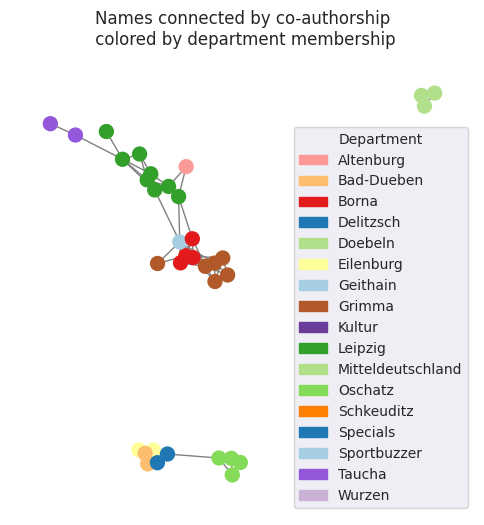

In [41]:
graph = nx.Graph()
graph.clear()

# Count the occurrences of each edge
edge_counts = {}
for edge in edges:
    key = tuple(sorted(edge))
    edge_counts[key] = edge_counts.get(key, 0) + 1

color_map = []

# Add nodes and weighted edges to the graph
for edge, count in edge_counts.items():
    node1, node2 = edge
    if count < 5:
        continue
    if not graph.has_node(node1):
        graph.add_node(node1)
        # add a color to the node
        color_map.append(static_color_map[author_departments[author_departments.name == node1].department.values[0]])
    if not graph.has_node(node2):
        graph.add_node(node2)
        # add a color to the node
        color_map.append(static_color_map[author_departments[author_departments.name == node1].department.values[0]])
    graph.add_edge(node1, node2, weight=count)

# display graph
plt.figure(figsize=[6, 6])
plt.title('Names connected by co-authorship\n colored by department membership')
nx.draw(graph, node_color=color_map, node_size=100, font_size=6.5, font_weight='bold', edge_color='gray')
# Create a dummy plot for the legend (this won't be visible, but it's necessary to create a legend)
import matplotlib.patches as mpatches
legend_patches = [mpatches.Patch(color=color, label=label) for label, color in static_color_map.items()]
plt.legend(handles=legend_patches, title='Department', loc='lower right')
plt.savefig('../reports/figures/department_exploration/names_co_authors_department_membership.png', dpi=200)

In [35]:
counts = departments.groupby('department').agg('count').sort_values(by='id', ascending=False).head(50).sort_values(by='id', ascending=True)

In [25]:
counts


,id,published_at,name
department,,,
Familie,20,20,20
Coronavirus,21,21,21
KWL,26,26,26
Achtung-Baustelle,28,28,28
Fluechtlinge-in-Leipzig,28,28,28
Hochwasser-in-Sachsen,31,31,31
Die-Akte-Unister,34,34,34
Wahl,39,39,39
Legida,43,43,43
